In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [4]:
image = cv2.imread('./img2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1920, 1080))

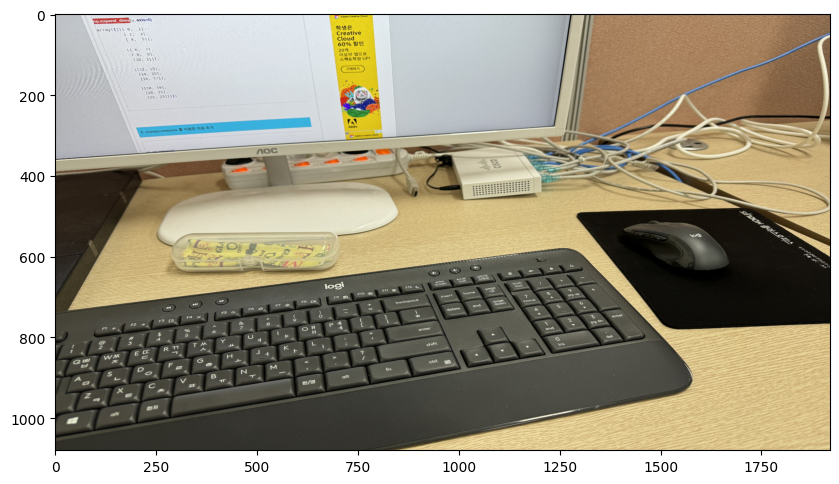

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [6]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [7]:
predictor.set_image(image)

In [8]:
input_point = np.array([[600, 850]])
input_label = np.array([1])

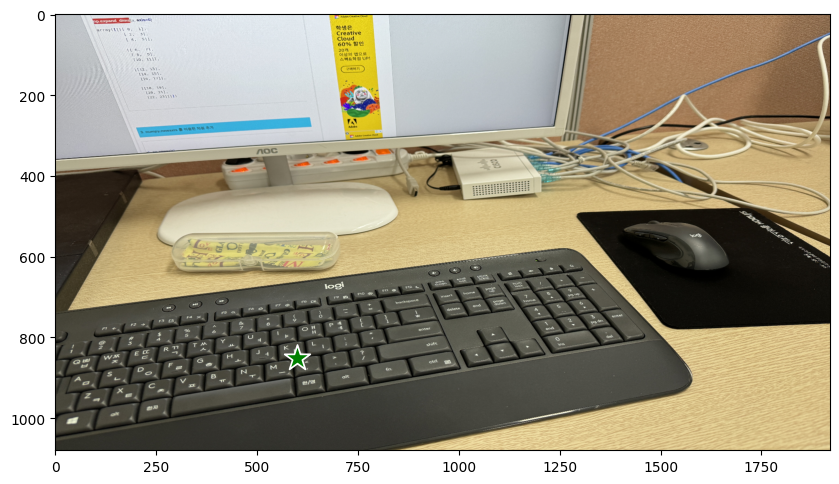

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [11]:
masks.shape  # (number_of_masks) x H x W

(3, 1080, 1920)

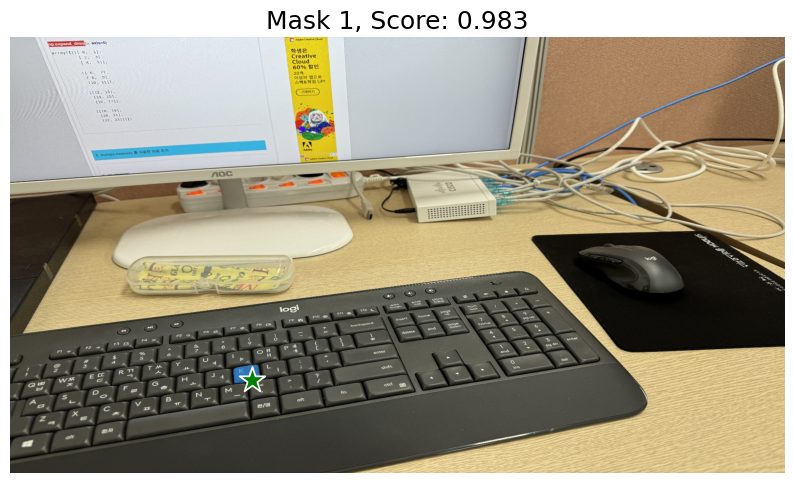

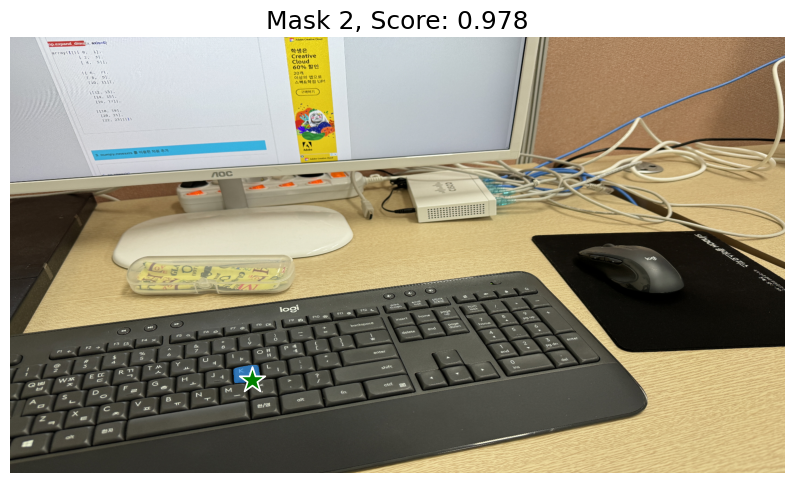

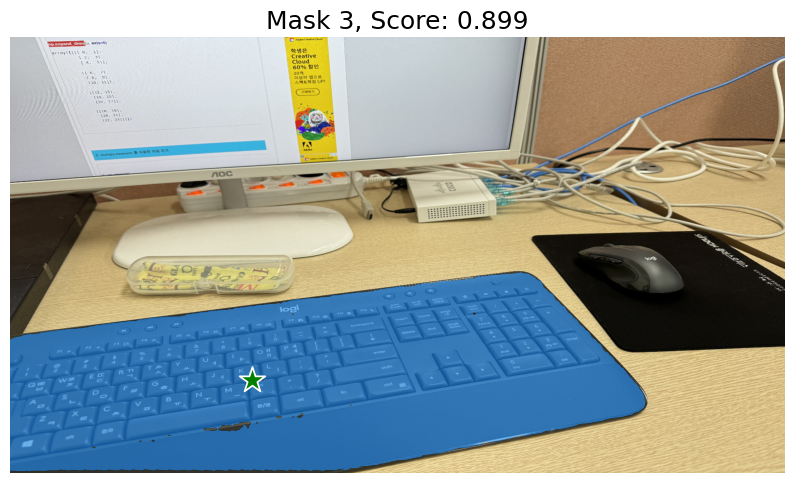

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [13]:
input_point = np.array([[600, 850], [900, 920]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

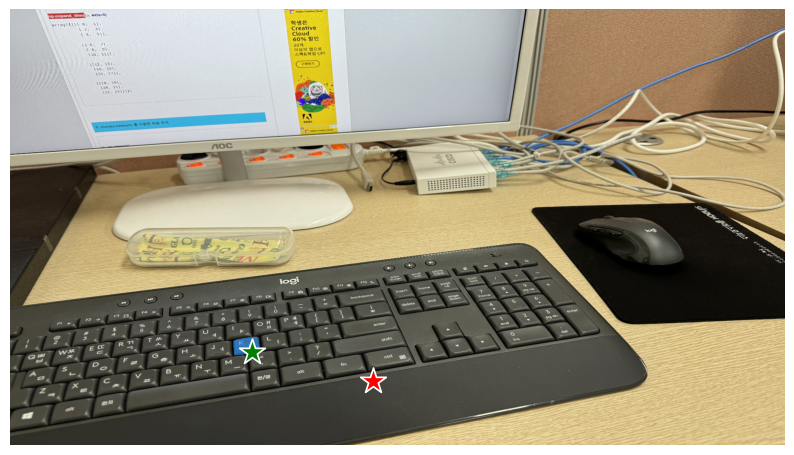

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [15]:
input_box = np.array([1400, 500, 1700, 650])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

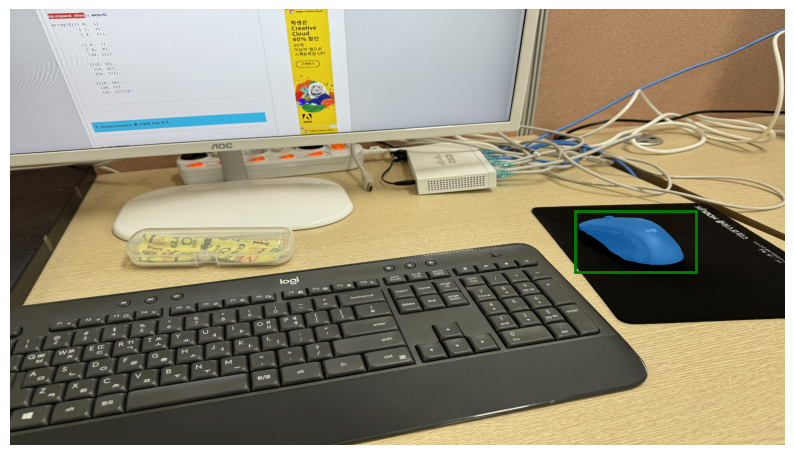

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [17]:
# img = cv2.imread('./img2.jpg')
# # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (1920, 1080))
# img_to_show = img.copy()

# input_point = []
# input_label = []
# mode = 1

# def mouse_event(event, x, y, flags, param):
#     global img_to_show, input_point, input_label, mode
    
#     if event == cv2.EVENT_LBUTTONDOWN:
#         if mode == 1:
#             cv2.circle(img_to_show, (x, y), 4, (0, 255, 0), -1)
#             input_point.append([x, y])
#             input_label.append(1)

#         elif mode == 2:
#             cv2.circle(img_to_show, (x, y), 4, (0, 0, 255), -1)
#             input_point.append([x, y])
#             input_label.append(0)

# cv2.namedWindow('image')
# cv2.setMouseCallback("image", mouse_event, img_to_show)
# file_path = './record.mp4'
# fps = 25.40
# fourcc = cv2.VideoWriter_fourcc(*'DIVX')            # 인코딩 포맷 문자
# width = 1920
# height = 1080
# size = (int(width), int (height))                   # 프레임 크기

# out = cv2.VideoWriter(file_path, fourcc, fps, size)

# while True:
#     cv2.imshow("image", img_to_show)

#     key = cv2.waitKey(33)

#     if key == ord("1"):
#         mode = 1

#     elif key == ord("2"):
#         mode = 2

#     elif key == ord("3"):
#         mode = 3

#     elif key == ord("q"):
#         break

#     elif key == ord("r"):
#         img_to_show = img.copy()
#         input_point = []
#         input_label = []
#         mode = 1

#     elif key == ord("d"):
#         if len(input_label) == 0:
#             pass
            
#         elif len(input_label) == 1:
#             masks, _, _ = predictor.predict(
#                 point_coords=np.array(input_point),
#                 point_labels=np.array(input_label),
#                 multimask_output=False,)

#             color = np.array([230, 100, 25])
#             h, w = masks.shape[-2:]
#             mask_image = masks.reshape(h, w, 1) * color.reshape(1, 1, -1).astype(np.uint8)
#             img_to_show = cv2.addWeighted(img_to_show, 0.7, mask_image, 0.3, 0) 

#         else:
#             print(input_label)
#             masks, scores, logits = predictor.predict(
#                 point_coords=np.array([input_point[0]]),
#                 point_labels=np.array([input_label[0]]),
#                 multimask_output=True,)
            
#             mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
        
#             masks, _, _ = predictor.predict(
#                 point_coords=np.array(input_point),
#                 point_labels=np.array(input_label),
#                 mask_input=mask_input[None, :, :],
#                 multimask_output=False,)

#             color = np.array([230, 100, 25])
#             h, w = masks.shape[-2:]
#             mask_image = masks.reshape(h, w, 1) * color.reshape(1, 1, -1).astype(np.uint8)
#             img_to_show = cv2.addWeighted(img_to_show, 0.7, mask_image, 0.3, 0) 

#     out.write(img_to_show) 

# out.release()
# cv2.destroyAllWindows()